# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

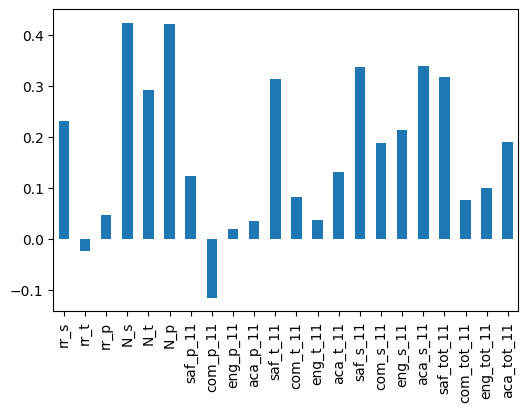

In [11]:
%matplotlib inline

# The .corr() method generates a dataframe of how much data in rows and columns correlate with one another.
# The ["sat_score"] selects just the correlations for the column named so
# and the [survey_fields] selects the rows relevant in our analysis, specified in our variable in box 2.
combined.corr()["sat_score"][survey_fields].plot.bar()

## Observations

`N_s` (Number of student respondents), `N_t` (Number of teacher respondents), `N_p` (Number of parent respondents), and `sat_score` are highly correlated, but these columns are also correlated with total_enrollment, so it would be surprising if they didn't show high correlation.

`rr_s` (Student Response Rate)—being a pecentage of students that completed the survey per school—correlates with that school's `sat_score`. Maybe this means that students that do well academically tend to fill out surveys, or perhaps schools that focus more on SAT scores simply push the surveys harder.

`saf_t_11` (Safety and Respect score based on teacher responses) and `saf_s_11` (Safety and Respect score based on student responses) correlate with sat_score. This might mean that schools that happen to be safe are also the schools that are able to focus on SAT scores more, or perhaps learning in general is enhanced by safe learning environments.

And finally, `aca_s_11` (Academic expectations score based on student responses) is correlated with `sat_score`, but `aca_t_11` (Academic expectations score based on teacher responses) and `aca_p_11` (Academic expectations score based on parent responses) are not correlated. It might be interesting to look further in the data and see why this is; perhaps parent and teacher expectations don't change from school to school, but student expectations do based on how much they prep for the SATs.

# Exploring Safety

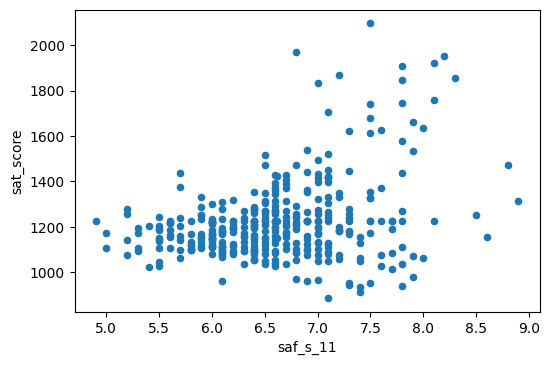

In [12]:
combined.plot.scatter("saf_s_11", "sat_score")

## Observations

Although there is a correlation between `sat_score` and `saf_s_11`, it isn't strong. Schools with safety scores below 6.5 have SAT score averages below 1500, schools with extremely high averages for SAT scores also have high safety ratings in the range of 6.5 to 8.5, but there are schools in the 7.0 to 7.5 range that have the absolute lowest average SAT scores. 

# Borough Safety

In [13]:
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


## Observations

Our read of safetey scores by geographic location (the five boroughs of New York) is actually 
fairly homogenous, these averages occupying a range of only 0.5. In that range, Manhattan and Queens have higher safety scores on average, and Brooklyn has lower safety scores on average.

# Racial differences in SAT scores

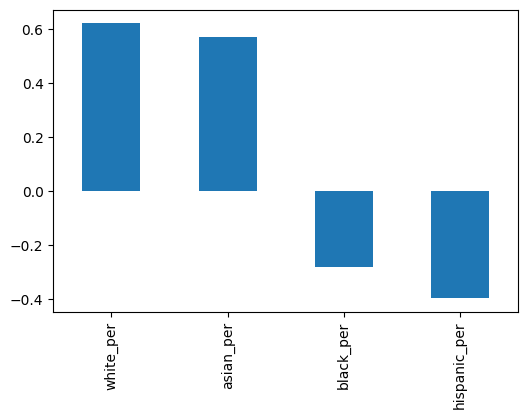

In [14]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

## Observations

Our correlations show that hite and asian students tend to have higher SAT scores tha black and hispanic students. This might be because of racial inequalities in social strata and thus different schools with different amounts of support and funding.

Next, let's check a scatter plot of school's SAT scores against the percentage of hispanic students those schools have, followed by a list of school names filtered to only include schools at which over 95% of their students are hispanic.

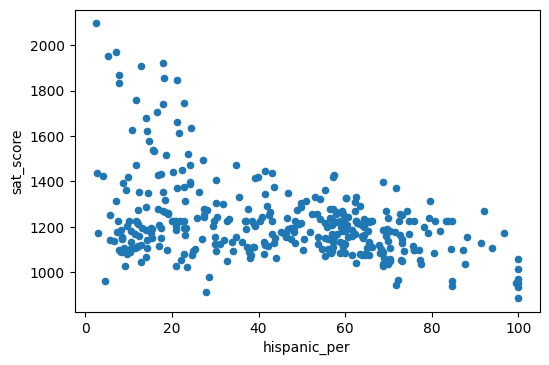

In [15]:
combined.plot.scatter("hispanic_per", "sat_score")

## Observations

There is a clear and strong negative correlation between the amount of hispanic students at a school and low SAT scores, but there are schools with few hispanic students that also have low SAT scores, so it is likely not an issue of being hispanic.

In [16]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## Observations

Some of the schools listed cater to hispanic students, such as the Pan American International High School at Monroe, which teaches all classes in English, but organizes students into teams so that students more proficient in English can explain concepts in Spanish to students who are less proficient in English.

Since the SAT is in English, and learning is more difficult for these students due to a language barrier, this could explain the low SAT scores.

In [17]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools listed are quite exclusive. Staten Island Tech requires admitted students to score high on the SHSAT. According to [this article:](https://www.bobbytariq.com/blog/what-does-staten-island-tech-specialize-in) "Of the 30,000 students who take the SHSAT each year, only about 300 seats are offered, making an acceptance rate of 1%." This alone doesn't explain why they have a low percentage of hispanic students, but it might be telling of why schools like this, who happen have low numbers of hispanic students, would also have high SAT scores.

The requirement system for attending such schools, passing a test, selects for students who are good at taking tests, and so it should be no surprise that their average aptitude for test-taking is high, and this is reflected by their SAT scores.